In [17]:
# Step 1: Install required packages
!pip install yfinance numpy pandas tensorflow matplotlib

In [18]:
# Step 2: Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [19]:
# Step 3: Download and prepare data
def get_stock_data(ticker="AAPL", start_date="2020-01-01", end_date="2025-01-01"):
    """Fetch stock data from Yahoo Finance"""
    data = yf.download(ticker, start=start_date, end=end_date)
    prices = data['Close'].values.reshape(-1, 1)
    return prices, data.index

prices, dates = get_stock_data()

[*********************100%***********************]  1 of 1 completed


In [20]:
# Step 4: Normalize data
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)


In [21]:
# Step 5: Create sequences for LSTM
def create_sequences(data, window_size=60):
    """Convert time series into supervised learning format"""
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(prices_scaled)

# Split into train/test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Get corresponding dates for test set
test_dates = dates[train_size+60:len(X)+60]  # Fixed date indexing

In [22]:
# Step 6: Build and train LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0684 - val_loss: 0.0053
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 9.2797e-04 - val_loss: 8.6480e-04
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 8.0554e-04 - val_loss: 8.5919e-04
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 7.8222e-04 - val_loss: 7.7171e-04
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 8.3279e-04 - val_loss: 8.4407e-04
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 8.2317e-04 - val_loss: 8.2675e-04
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.7792e-04 - val_loss: 9.2033e-04
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.6267e-04 - val_loss: 7.0388e-04
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.3509e-04 - val_loss: 6.8119e-04
Epoch 12/2

In [23]:
# Step 7: Make predictions and detect anomalies
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate errors (ensure 1D array)
errors = np.abs(y_test_actual.flatten() - predictions.flatten())  # Fixed flattening
anomaly_threshold = np.percentile(errors, 95)
anomalies = errors > anomaly_threshold  # This is now guaranteed to be 1D

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


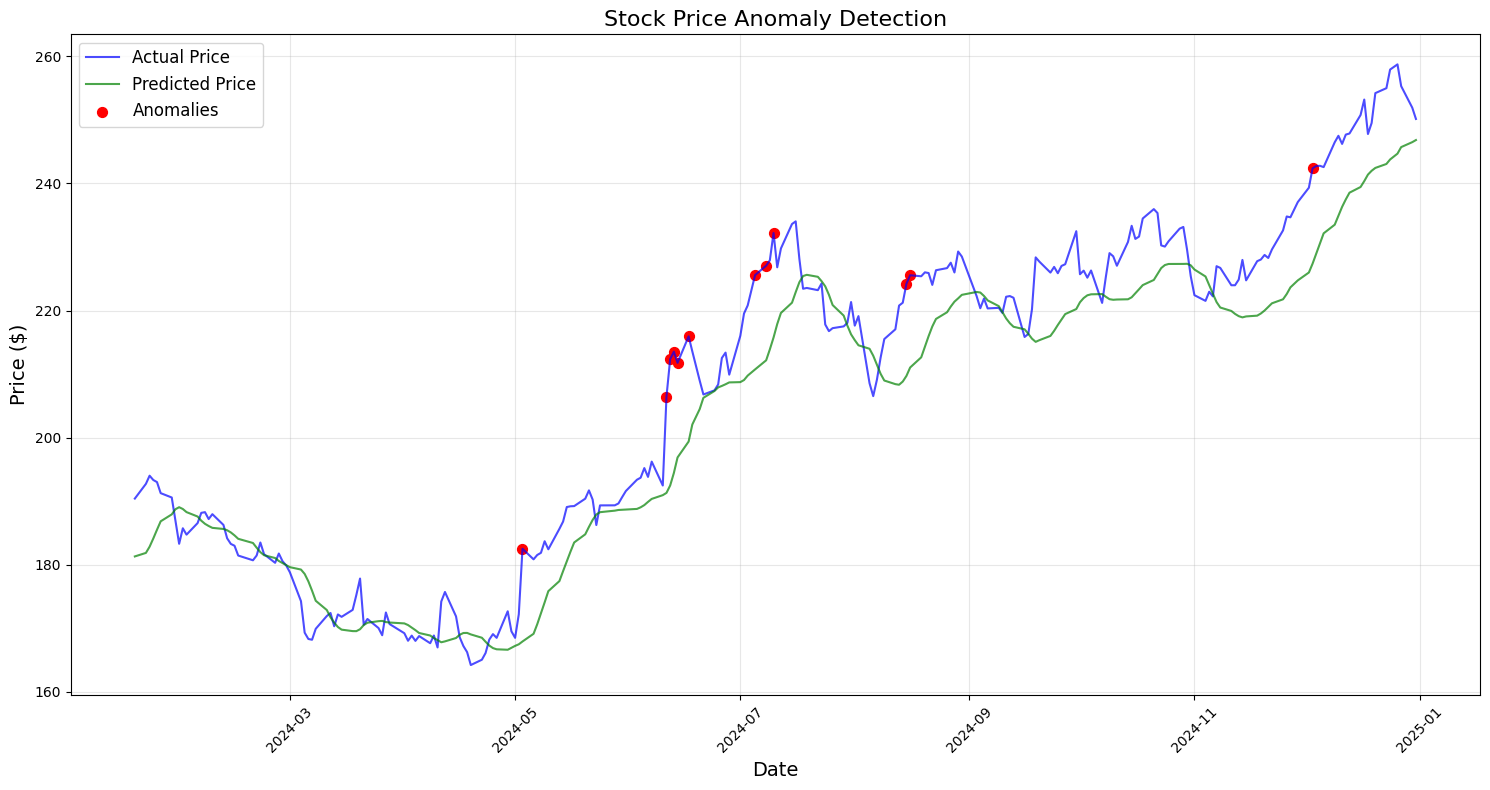

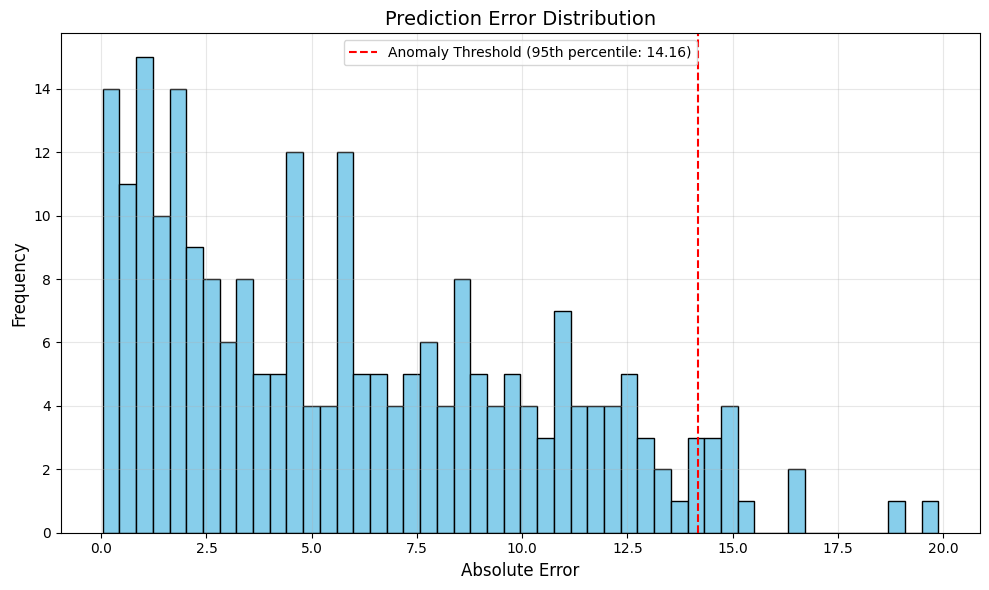

In [24]:
# Step 8: Visualize results (FIXED indexing)
plt.figure(figsize=(15, 8))

# Convert test_dates to numpy array for proper indexing
test_dates_array = test_dates.to_numpy()

# Plot actual prices
plt.plot(test_dates_array, y_test_actual, label='Actual Price', color='blue', alpha=0.7)

# Plot predicted prices
plt.plot(test_dates_array, predictions, label='Predicted Price', color='green', alpha=0.7)

# Highlight anomalies - FIXED indexing
plt.scatter(test_dates_array[anomalies],  # Direct boolean indexing on numpy array
            y_test_actual[anomalies],
            color='red', label='Anomalies', s=50)

# Formatting
plt.title('Stock Price Anomaly Detection', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additional diagnostic plot
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
plt.axvline(anomaly_threshold, color='red', linestyle='--',
            label=f'Anomaly Threshold (95th percentile: {anomaly_threshold:.2f})')
plt.title('Prediction Error Distribution', fontsize=14)
plt.xlabel('Absolute Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
